In [ ]:
import matplotlib.pyplot as plt # visualization
import missingno as msno # missing data visualization
import numpy as np # array manipulation
import pandas as pd # dataframe manipulation
import scipy # statistical tests
import seaborn as sns # visualization
from zipfile import ZipFile # reading zip file
import random

In [49]:
train_zip_file_path = "D:\\Winton-Challenge\\train.csv.zip"
test_zip_file_path = "D:\\Winton-Challenge\\test_2.csv.zip"
train_file = ZipFile(train_zip_file_path)
test_file = ZipFile(test_zip_file_path)
train = pd.read_csv(train_file.open("train.csv"))
test =  pd.read_csv(test_file.open("test_2.csv"))

In [ ]:
train.describe()

# Features
1. 1-25 are values that govern stock points of a particular stock
2. Some are categorical some are discrete
3. There are many missing values for some features -> WE could try to impute this either by using **k-nearest neighbour(expensive)** or **other clusterisng methods(mean, median or mode)** or **Scikit-learn's IterativeImputer**

> **Hypothesis** : Feautre_1, Feature_5, Feature_10, Feature_13, Feature_16 and Feature_20 are categorical

In [ ]:
#To make inferences about Feature
train.iloc[:, 1:26].hist(bins=50, figsize=(30,20))

plt.show()

# Returns
1. Ret_MinusTwo:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
2. Ret_MinusOne: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
3. Ret_2 to Ret_120: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 
4. Ret_121 to Ret_180: intraday returns over approximately one minute on day D. These are the target variables you need to predict as {id}_{1-60}. 
5. Ret_PlusOne: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1 day). **This is a target variable you need to predict as {id}_61.** 
6. Ret_PlusTwo: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) **This is a target variable you need to predict as {id}_62.** 

> Different Stocks have different type of returns( variational, oscillating between two-three points, not varying at all)

> This could indicate category of different stocks that follow a similiar rule

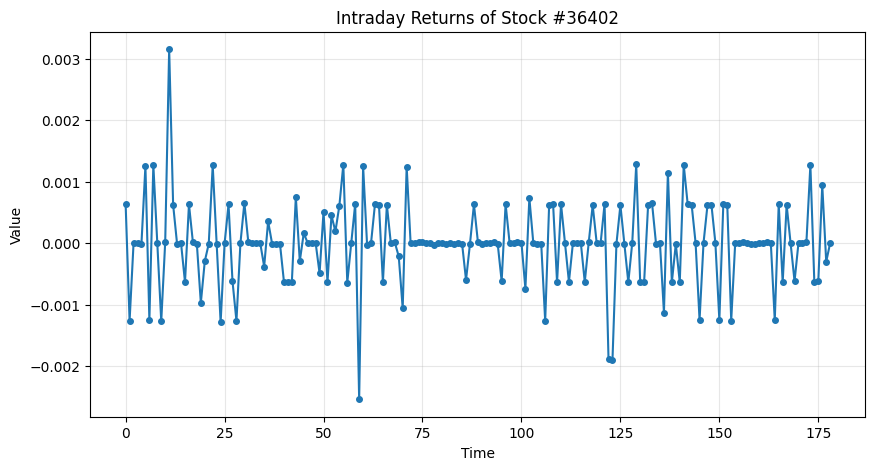

In [41]:
#To make inference about stock's nature i.e. Returns
def plot_random_stock(train, feature_slice=(28,207)):
    rng = np.random.default_rng()
    rando_id = rng.integers(0, len(train))
    stock_val_intraday = train.iloc[rando_id, slice(*feature_slice)].to_numpy()
    x = np.arange(stock_val_intraday.size)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, stock_val_intraday, '-o', markersize=4, linewidth=1.5)
    plt.title(f"Intraday Returns of Stock #{rando_id}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.show()

plot_random_stock(train)

# Weights 
> This is used for calculating **Mean Absolute Error** for the predictions
1. Weight_Intraday: weight used to evaluate intraday return predictions Ret 121 to 180
2. Weight_Daily: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).
3. Weights have exactly the **same distribution** just scaled differently
4. These variables should **not** be taken for prediction models


In [ ]:
#To make inferences about Weights

train.loc[:,["Weight_Daily","Weight_Intraday"]].hist(bins= 50, figsize=(12,8))

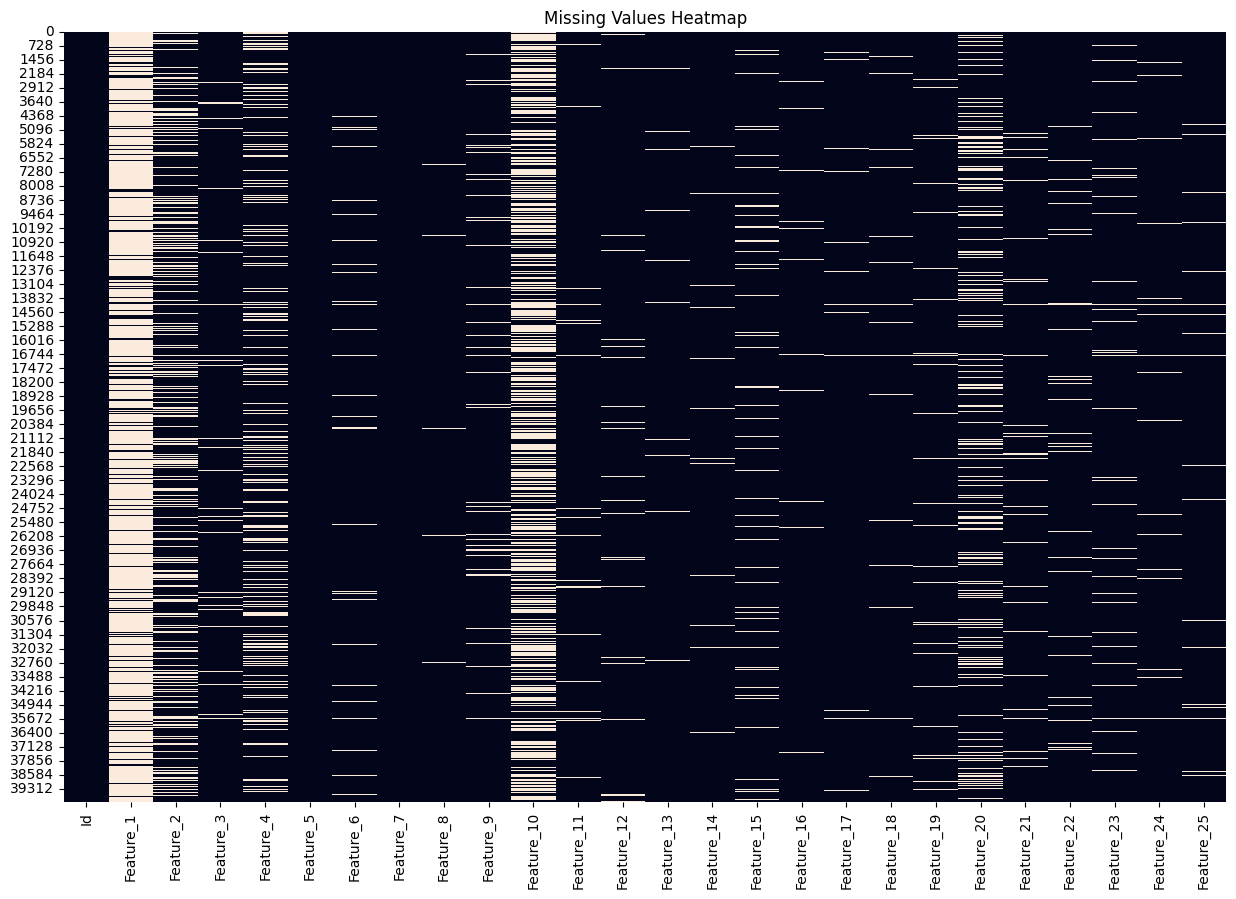

Id                  0.0000
Feature_1          83.2825
Feature_2          22.8650
Feature_3           3.0925
Feature_4          19.3025
                    ...   
Ret_180             0.0000
Ret_PlusOne         0.0000
Ret_PlusTwo         0.0000
Weight_Intraday     0.0000
Weight_Daily        0.0000
Length: 211, dtype: float64
Coloumns with NO missing values:
['Id', 'Feature_5', 'Feature_7', 'Ret_MinusTwo', 'Ret_MinusOne', 'Ret_120', 'Ret_121', 'Ret_122', 'Ret_123', 'Ret_124', 'Ret_125', 'Ret_126', 'Ret_127', 'Ret_128', 'Ret_129', 'Ret_130', 'Ret_131', 'Ret_132', 'Ret_133', 'Ret_134', 'Ret_135', 'Ret_136', 'Ret_137', 'Ret_138', 'Ret_139', 'Ret_140', 'Ret_141', 'Ret_142', 'Ret_143', 'Ret_144', 'Ret_145', 'Ret_146', 'Ret_147', 'Ret_148', 'Ret_149', 'Ret_150', 'Ret_151', 'Ret_152', 'Ret_153', 'Ret_154', 'Ret_155', 'Ret_156', 'Ret_157', 'Ret_158', 'Ret_159', 'Ret_160', 'Ret_161', 'Ret_162', 'Ret_163', 'Ret_164', 'Ret_165', 'Ret_166', 'Ret_167', 'Ret_168', 'Ret_169', 'Ret_170', 'Ret_171', 'Ret_

In [56]:
plt.figure(figsize=(15,10))
sns.heatmap(train.iloc[:,0:26].isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

missing_counts = train.isnull().sum()
zero_missing = missing_counts[missing_counts == 0]
percentage_missing_large = (train.isnull().sum() / len(train) * 100)#.loc[lambda x: x > 30].index.tolist()

print(percentage_missing_large)
print("Coloumns with NO missing values:")
print(zero_missing.index.tolist())

- So it seems that the variables to predict do not have any missing values in the **train dataset**. This is good news.
- Various Ids have their return values missing in the training data we can discard them or use imputation methods to interpolate the data.
- We could use the 
    1. Moving avg or
    2. Feedforward fill or
    3. Interpolation

# Observations from the missing data heatmap
1. Feature_1 is absent for 83% of stock Ids this can be dropped or used as feature_1_na coloumn.
2. Feature_10 is absent for 48.65% of stock Ids this can dropped or used as feature_10_na coloumn.
3. Feature_5 and Feature_7 are fully present and were thought of as categorical in our hypothesis.

# Ideas
1. stocks in same sector in the market would have similiar fluctutions
    - Could create a dataframe to track the percentage or relative increase/decrease in stock values(**DO NOT INCLUDE VARIABLES THAT NEED TO PREDICTED, THIS WILL CREATE A BIAS**) to so as to make a cluster of similiar stocks
    - Then we will use these clusters to make categorical assumptions of the Features and make rules for the features which define the stock clusters
    - This would most likely involve "Forest Search" algos.
2. After making Clustering rules for stocks we would have to predict the **Ret_121 to Ret_180 and Ret_PlusOne and Ret_PlusTwo**


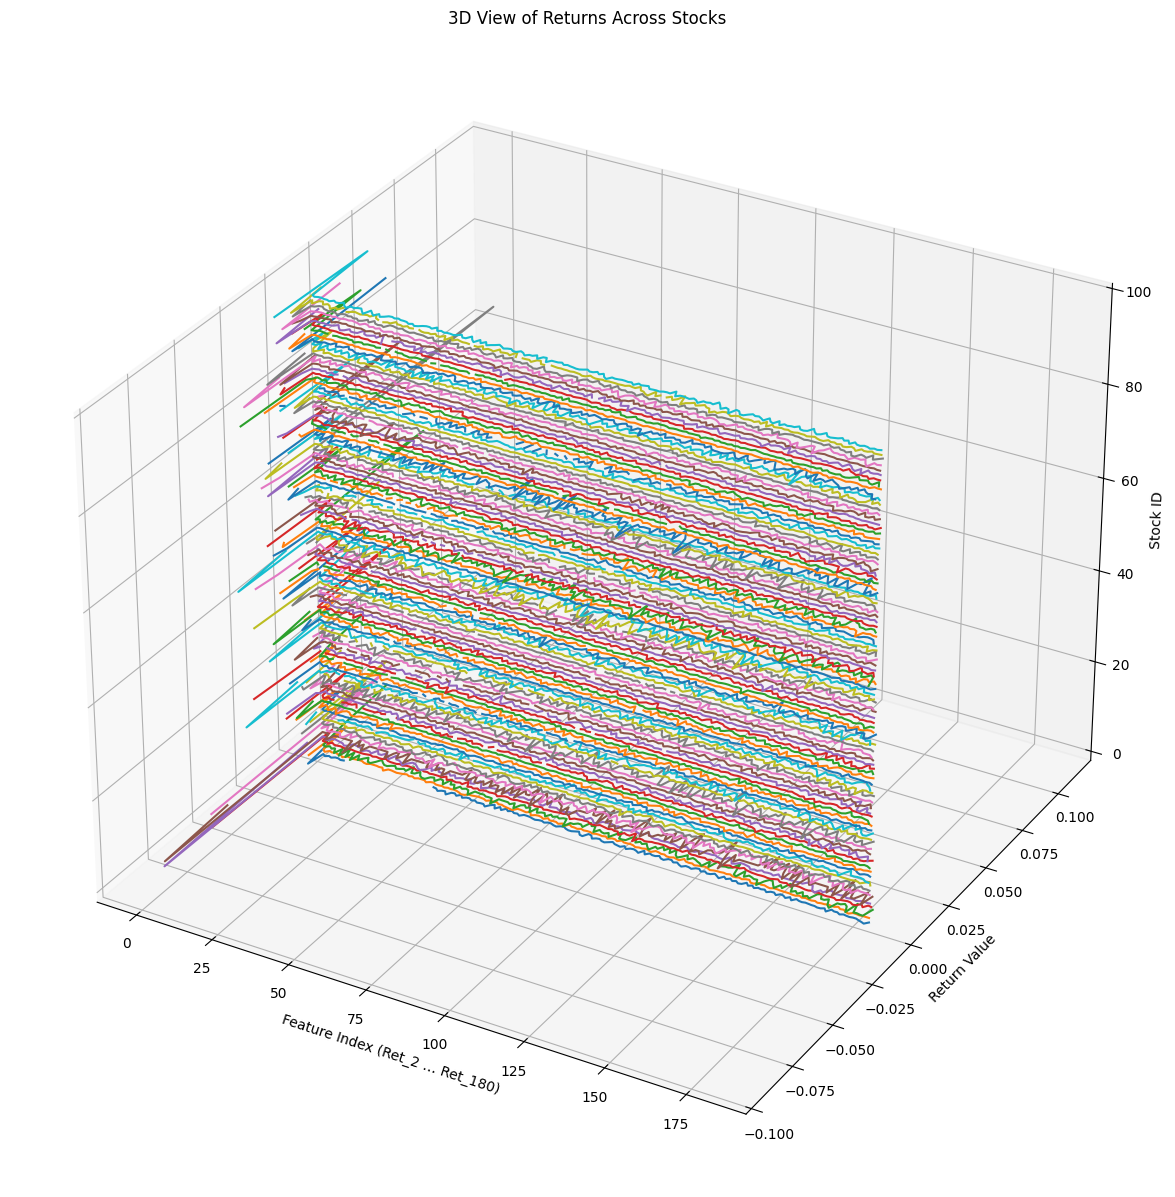

In [129]:
#plotting sample of stocks 
from mpl_toolkits.mplot3d import Axes3D
cols = [col for col in train.columns if col.startswith("Ret_") and col not in ["Ret_PlusOne", "Ret_PlusTwo"]]

sample_df = train.sample(n=100)[cols]
x = np.arange(len(cols))

fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection= "3d")

for i, row in enumerate(sample_df.to_numpy()):
    y= row
    z = np.full_like(x,i)
    ax.plot(x,y,z, label =f"Stock{i}" if i <3 else "")

ax.set_xlabel("Feature Index (Ret_2 … Ret_180)")
ax.set_ylabel("Return Value")
ax.set_zlabel("Stock ID")
ax.set_title("3D View of Returns Across Stocks") 
plt.show()
